# Decision tree with information gain based feature selection


In [1]:
import numpy as np
import pandas as pd
import heapq
import math

In [2]:
class Node:
    def __init__(self, left, right, is_leaf, feature, info_gain):
        self.left = left
        self.right = right
        self.is_leaf = is_leaf
        self.feature:int = feature
        self.info_gain = info_gain
        self.label = None

class PQData:
    def __init__(self, info_gain, feature, passed, avail_docs, node):
        self.info_gain = info_gain
        self.feature = feature
        self.passed:set = passed
        self.avail_docs:list[int] = avail_docs
        self.node: Node = node
    
    def __lt__(self, other):
        if not isinstance(other, PQData):
            return NotImplemented
        return self.info_gain < other.info_gain

class DecisionTree:
    def __init__(self, eval):
        self.eval = eval
        self.pq: list[PQData] = []

        # parsing input data
        self.train_labels = {}
        with open('data/trainLabel.txt', 'r') as f:
            for i, j in enumerate(f, 1):
                self.train_labels[i] = int(j)

        self.test_labels = {}
        with open('data/testLabel.txt', 'r') as f:
            for i, j in enumerate(f, 1):
                self.test_labels[i] = int(j)

        self.train_data = {}
        self.word_to_doc = {}
        with open('data/trainData.txt', 'r') as f:
            for i, j in enumerate(f, 1):
                doc, word = j.split(' ')

                temp = self.train_data.get(int(doc), set())
                temp.add(int(word))
                self.train_data[int(doc)] = temp

                temp = self.word_to_doc.get(int(word), set())
                temp.add(int(doc))
                self.word_to_doc[int(word)] = temp

        self.test_data = {}
        with open('data/testData.txt', 'r') as f:
            for i, j in enumerate(f, 1):
                doc, word = j.split(' ')
                temp = self.test_data.get(int(doc), set())
                temp.add(int(word))
                self.test_data[int(doc)] = temp

        self.words = {}
        with open('data/words.txt', 'r') as f:
            for i, j in enumerate(f, 1):
                self.words[i] = j.strip()

        # init the struct 
        self.root = Node(None, None, True, None, None)
        root_data = PQData(None, None, set(), list(self.train_data.keys()), self.root)
        root_gain, root_data.feature = self.find_best_feature(root_data)
        root_data.info_gain = -root_gain
        self.pq.append(root_data)

        # populate leaf
        self.root.info_gain = root_data.info_gain
        self.root.is_leaf = True
        self.root.feature = root_data.feature
        self.label = self.estimate(list(self.train_data.keys()))


    def find_best_feature(self, el: PQData):
        score = max_feature_score = 0
        max_feature = None
        for word in self.words.keys():
            if word in el.passed:
                continue

            score = self.calc_split(word, el.avail_docs)
            if score > max_feature_score:
                max_feature = word
                max_feature_score = score
    
        return max_feature_score, max_feature
    
    def calc_split(self, word: str, avail_docs: list[int]):
        avail_docs = set(avail_docs)
        contains = set()
        missing = set()

        for doc in avail_docs:
            if word in self.train_data[doc]:
                contains.add(doc)
            else:
                missing.add(doc)
        
        ie = self.get_ie(avail_docs)
        ie1 = self.get_ie(contains)
        ie2 = self.get_ie(missing)
        
        if self.eval == 'Weighted':
            total_len = len(contains) + len(missing)
            weighted_gain = ie - (len(contains) / total_len * ie1 + len(missing) / total_len * ie2)
            return weighted_gain
        else:
            return ie - (1/2 * ie1 + 1/2 * ie2)
    
    # select list of docs
    def get_ie(self, select: set[int]):
        c1 = c2 = 0

        for doc in select:
            if self.train_labels[doc] == 1:
                c1 += 1
            else:
                c2 += 1

        total = c1 + c2
        if total == 0:
            return 0
        c1_term = 0
        c2_term = 0
        if c1 != 0:
            c1_term =  c1 / total * math.log2(c1/total) 

        if c2 != 0:
            c2_term =  c2 / total * math.log2(c2/total) 

        return - c1_term - c2_term
        
    def estimate(self, select):
        # output majority class

        c1 = c2 = 0
        for doc in select:
            if self.train_labels[doc] == 1:
                c1 += 1
            else:
                c2 += 1
        
        return 1 if c1 > c2 else 2

    def _eval(self, type: str):
        data = None
        labels = None
        if type == 'train':
            data = self.train_data
            labels = self.train_labels
        else:
            data = self.test_data
            labels = self.test_labels
        
        correct = incorrect = 0
        for doc, word_set in data.items():
            true_label = labels[doc]


            curnode = self.root
            while curnode and not curnode.is_leaf:
                if curnode.feature in word_set:
                    curnode = curnode.left
                else:
                    curnode = curnode.right
            
            if curnode.label != true_label:
                incorrect += 1
            else:
                correct += 1
        
        return correct / (incorrect + correct)


    def train(self, splits):
        train_res = []
        test_res = []

        for _ in range(splits):
            el = heapq.heappop(self.pq)

            # populate parent fields after pop
            parent = el.node
            parent.info_gain = el.info_gain
            parent.is_leaf = False
            parent.feature = el.feature
            parent.label = self.estimate(el.avail_docs)

            # prepare children features
            split_feature = el.feature
            # parent.left = Node(None, None, True, None, None)
            # parent.right = Node(None, None, True, None, None)

            # split data
            contains = []
            missing = []

            for doc in el.avail_docs:
                if split_feature in self.train_data[doc]:
                    contains.append(doc)
                else:
                    missing.append(doc)

            left_child = PQData(None, None, el.passed.copy() | {split_feature}, contains, None)
            right_child = PQData(None, None, el.passed.copy() | {split_feature}, missing, None)
            left_gain, left_child.feature = self.find_best_feature(left_child)
            left_child.info_gain = -left_gain
            right_gain, right_child.feature = self.find_best_feature(right_child)
            right_child.info_gain = -right_gain

            left_node = Node(None, None, True, None, None)
            right_node = Node(None, None, True, None, None)
            left_node.label = self.estimate(contains)
            right_node.label = self.estimate(missing)
            left_node.feature, left_node.info_gain = left_child.feature, left_gain
            right_node.feature, right_node.info_gain = right_node.feature, right_gain

            left_child.node = left_node
            right_child.node = right_node

            parent.left = left_node
            parent.right = right_node

            if len(left_child.avail_docs) > 0:
                heapq.heappush(self.pq, left_child)

            if len(right_child.avail_docs) > 0:
                heapq.heappush(self.pq, right_child)  

             # eval train / test
            train_acc = self._eval("train")
            test_acc = self._eval("test")
            train_res.append(train_acc)
            test_res.append(test_acc)    
            # print(train_acc, test_acc, self.words[parent.feature])
            
        return train_res, test_res  

In [3]:
weighted = DecisionTree('Weighted')
weighted_acc = weighted.train(100)

avg = DecisionTree('avg')
avg_acc = avg.train(100)

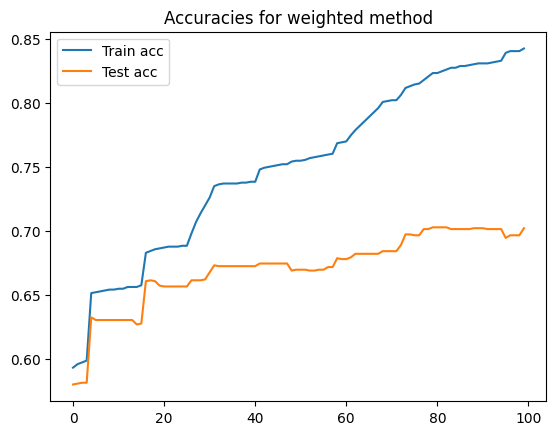

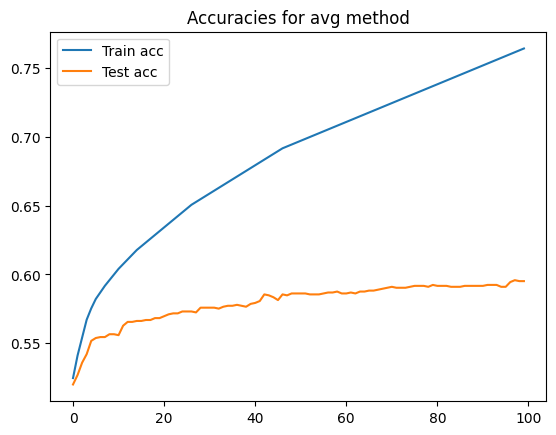

In [4]:
import matplotlib.pyplot as plt

plt.plot(weighted_acc[0], label='Train acc')
plt.plot(weighted_acc[1], label='Test acc')
plt.legend()
plt.title("Accuracies for weighted method")
plt.show()

plt.plot(avg_acc[0], label='Train acc')
plt.plot(avg_acc[1], label='Test acc')
plt.legend()
plt.title("Accuracies for avg method")
plt.show()